In [1]:
# pip install pandas

In [2]:
# pip install mysql-connector-python

In [3]:
# import pandas as pd
# import mysql.connector
# import os

# # List of CSV files and their corresponding table names
# csv_files = [
#     ('customers.csv', 'customers'),
#     ('orders.csv', 'orders'),
#     ('sellers.csv', 'sellers'),
#     ('products.csv', 'products'),
#     ('order_items.csv', 'order_items'),
#     ('payments.csv', 'payments'),
#     ('geolocations.csv', 'geolocations') # Added payments.csv for specific handling
# ]

# # Connect to the MySQL database
# conn = mysql.connector.connect(
#     host='localhost',
#     user='root',
#     password='nitish@123',
#     database='e_commerce_sale'
# )
# cursor = conn.cursor()

# # Folder containing the CSV files
# folder_path = 'C:/Users/nk121/Desktop/project demo/e-Commerce sale analysis/archive'

# def get_sql_type(dtype):
#     if pd.api.types.is_integer_dtype(dtype):
#         return 'INT'
#     elif pd.api.types.is_float_dtype(dtype):
#         return 'FLOAT'
#     elif pd.api.types.is_bool_dtype(dtype):
#         return 'BOOLEAN'
#     elif pd.api.types.is_datetime64_any_dtype(dtype):
#         return 'DATETIME'
#     else:
#         return 'TEXT'

# for csv_file, table_name in csv_files:
#     file_path = os.path.join(folder_path, csv_file)
    
#     # Read the CSV file into a pandas DataFrame
#     df = pd.read_csv(file_path)
    
#     # Replace NaN with None to handle SQL NULL
#     df = df.where(pd.notnull(df), None)
    
#     # Debugging: Check for NaN values
#     print(f"Processing {csv_file}")
#     print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

#     # Clean column names
#     df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

#     # Generate the CREATE TABLE statement with appropriate data types
#     columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
#     create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
#     cursor.execute(create_table_query)

#     # Insert DataFrame data into the MySQL table
#     for _, row in df.iterrows():
#         # Convert row to tuple and handle NaN/None explicitly
#         values = tuple(None if pd.isna(x) else x for x in row)
#         sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
#         cursor.execute(sql, values)

#     # Commit the transaction for the current CSV file
#     conn.commit()

# # Close the connection
# conn.close()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import mysql.connector

db = mysql.connector.connect(host = 'localhost',
                            username = 'root',
                            password = 'nitish@123',
                            database = 'e_commerce_sale')

cur = db.cursor()

# List all unique cities where customers are located?

In [5]:
query = """
SELECT DISTINCT
    customer_city
FROM
    customers
LIMIT 5;"""

cur.execute(query)

data = cur.fetchall()

data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',)]

# count the number of orders placed in 2017?

In [6]:
query = """
SELECT 
    COUNT(order_id)
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2017;"""

cur.execute(query)

data = cur.fetchall()

'total order placed in 2017', data[0][0]

('total order placed in 2017', 45101)

# Find the total sale per category?

In [7]:
query = """SELECT 
    UPPER(products.product_category) AS category,
    ROUND(SUM(payments.payment_value), 2) AS sale
FROM
    products AS products
        JOIN
    order_items AS oi ON products.product_id = oi.product_id
        JOIN
    payments AS payments ON oi.order_id = payments.order_id
GROUP BY category;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category", "sale"])

df

,category,sale
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments?

In [8]:
query = """
SELECT 
    SUM(CASE
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END) / COUNT(*) * 100
FROM
    payments;"""

cur.execute(query)

data = cur.fetchall()

print("the percentage of orders that were paid in installments", data[0][0])

the percentage of orders that were paid in installments 99.9981


# Count the number of customer from each state?

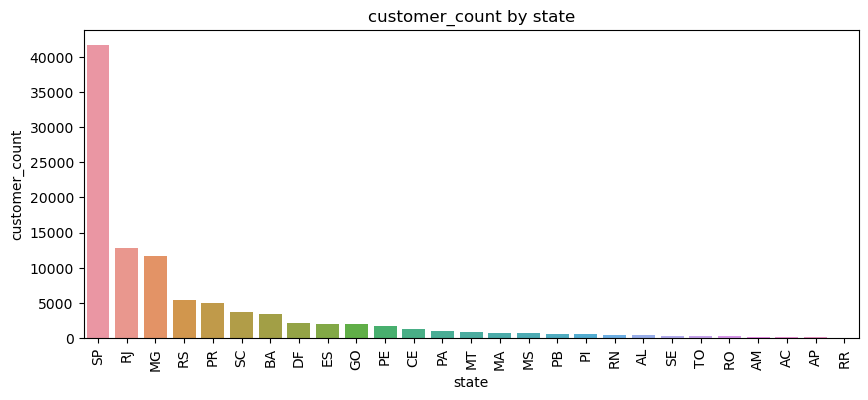

In [9]:
query = """
SELECT 
    customer_state, COUNT(customer_id)
FROM
    customers
GROUP BY customer_state;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['state', 'customer_count'])
df = df.sort_values(by = 'customer_count', ascending = False)

# shows the visualization

plt.figure(figsize = (10,4))
sns.barplot(x = df['state'], y = df['customer_count'])
plt.title("customer_count by state")
plt. xticks(rotation = 90)
plt.show()

# Calculate the number of order per month in 2018?

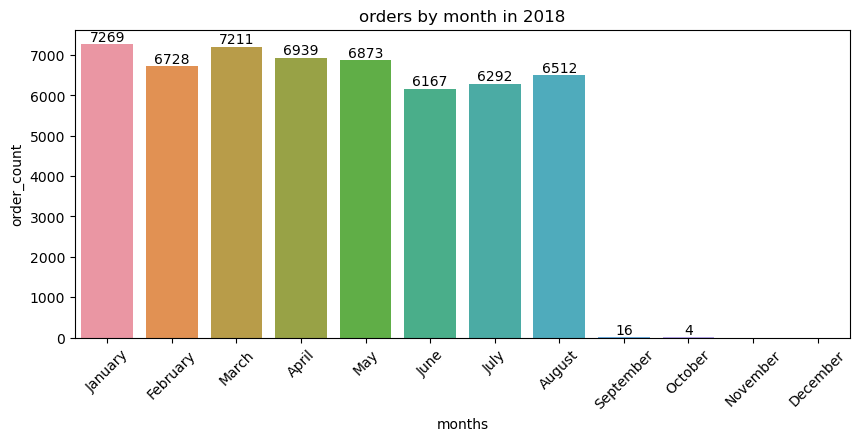

In [10]:
query = """
SELECT 
    MONTHNAME(order_purchase_timestamp) AS months,
    COUNT(order_id) AS order_count
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY months;"""

cur.execute(query)

data = cur.fetchall()

# show the visualizations
df = pd.DataFrame(data, columns = ['months', 'order_count'])
o = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize = (10,4))
ax = sns.barplot(x = df['months'], y = df['order_count'], order = o)
ax.bar_label(ax.containers[0])
plt.title("orders by month in 2018")
plt.xticks(rotation = 45)
plt.show()

# Find the average number of product per order, grouped by customer city?

In [11]:
query = """
with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count
from orders
join order_items on orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, avg(count_per_order.order_count) as average_order
from customers
join count_per_order on customers.customer_id = count_per_order.customer_id
group by customer_city
order by average_order desc;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['city', 'avg product per order'])
df.head(10)

,city,avg product per order
0,padre carvalho,7.0000
1,celso ramos,6.5000
2,datas,6.0000
3,candido godoi,6.0000
4,matias olimpio,5.0000
5,cidelandia,4.0000
6,picarra,4.0000
7,morro de sao paulo,4.0000
8,teixeira soares,4.0000
9,curralinho,4.0000


# Calculate the percentage of total revenue contributed by each product category?

In [12]:
query = """select upper(products.product_category) as category,
round(sum(payments.payment_value)/(select sum(payment_value) from payments)*100, 2) as sale_perc
from products
join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by category
order by sale_perc desc;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['category', 'sale_perc'])

df.head(10)

,category,sale_perc
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# Identify the correlation between product price and the number of times product has been purchased?

In [13]:
query = """select products.product_category, count(order_items.product_id) counts, avg(order_items.price) as avg_price
from products
join order_items
on products.product_id = order_items.product_id
group by products.product_category;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['product_category', 'counts', 'avg_price'])
df
arr1 = df['counts']
arr2 = df['avg_price']
a = np.corrcoef(arr1, arr2)
'the correlation is', a[0][-1]

('the correlation is', -0.10631552237549528)

# Calculate the total revenue generated by each seller, and rank them by revenue?

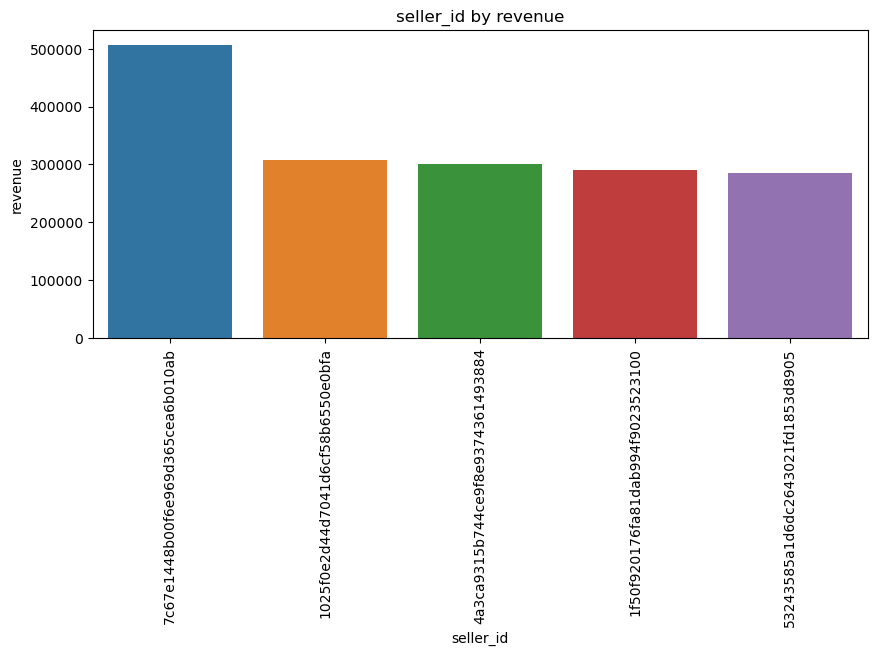

In [14]:
query = """with cte_table as (select order_items.seller_id, sum(payments.payment_value) as revenue
from order_items
join payments on order_items.order_id = payments.order_id
group by order_items.seller_id
order by revenue desc)
select *,
dense_rank() over(order by revenue desc) as rn from cte_table;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['seller_id', 'revenue', 'rn'])
df = df.head()
plt.figure(figsize = (10,4))
sns.barplot(x = df['seller_id'], y = df['revenue'])
plt.title("seller_id by revenue")
plt. xticks(rotation = 90)
plt.show()


# Calculate the moving average of order values for each customer over their order history?

In [15]:
query = """select *,
avg(payment_value) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value
from orders
join payments
on orders.order_id = payments.order_id) as temp_table"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_id', 'order_purchase_timestamp', 'payment_value', 'moving_avg'])

df

,customer_id,order_purchase_timestamp,payment_value,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year?

In [16]:
query = """select *, round(sum(payment) over(order by years, months)) as cumulative_sum
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value)) as payment
from orders
join payments on orders.order_id = payments.order_id
group by years, months) as temp_table"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['years', 'months', 'payment', 'cumulative_sum'])

df

,years,months,payment,cumulative_sum
0,2016,9,252.0,252.0
1,2016,10,59090.0,59342.0
2,2016,12,20.0,59362.0
3,2017,1,138488.0,197850.0
4,2017,2,291908.0,489758.0
5,2017,3,449864.0,939622.0
6,2017,4,417788.0,1357410.0
7,2017,5,592919.0,1950329.0
8,2017,6,511276.0,2461605.0
9,2017,7,592383.0,3053988.0


# Calculate the year-over-year growth rate of total sales?

In [17]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase?

In [18]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year?

In [19]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "customer_id", "payment", "d_rank"])
df

,years,customer_id,payment,d_rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3
